In [25]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import joblib

In [3]:
file_path = 'dengue_data1.csv'
split_index = 143

In [5]:
data = pd.read_csv(file_path)

In [7]:
features = ['pr', 'pr_1', 'tas', 'tas_1', 'tasmax', 'tasmax_1', 'tasmin', 'tasmin_1', 
            'deltemp', 'deltemp_1', 'dengue_befor', 'dengue_befor_1']
X = data[features]
y = data['dengue_incidence']

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [9]:
param_grid = {
    'n_estimators': [6],
    'max_depth': [100],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': [1, 'sqrt']
}

In [11]:
def r_squared(y_true, y_pred):
    """Compute the R-squared value for two arrays of data."""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_sum = np.sum((y_pred-np.mean(y_pred))*(y_true-np.mean(y_true)))
    ss_res = (np.sum((y_pred - np.mean(y_pred)) ** 2) * np.sum((y_true - np.mean(y_true)) ** 2))**0.5
    return (y_pred_sum/ss_res)**2

In [13]:
def train_and_evaluate_model(X_train, y_train, X_test, y_test, param_grid):
    rf = RandomForestRegressor()
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, 
                               scoring='neg_mean_absolute_percentage_error')
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    predictions = best_model.predict(X_test)
    r2 = r_squared(y_test, predictions)  
    mae = mean_absolute_error(y_test, predictions)
    
    return grid_search, r2, mae

In [15]:
r2_best, mae_best = -np.inf, np.inf
iteration = 0

# Create a directory to store all results
results_dir = f"dengue_model_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
os.makedirs(results_dir, exist_ok=True)

In [17]:
best_models = []

# Define max iterations
max_iterations = 100  # Run exactly 100 iterations

iteration = 0

# make 100 loops
while iteration < max_iterations:
    iteration += 1
    model, r2, mae = train_and_evaluate_model(X_train, y_train, X_test, y_test, param_grid)
    
    print(f"Iteration {iteration}: R2 = {r2}, MAE = {mae}")
    
    # Store each model regardless of performance
    best_models.append({
        'iteration': iteration,
        'model': model.best_estimator_,
        'R2': r2,
        'MAE': mae,
        'best_params': model.best_params_
    })
    
# Sort the models by R² (descending) and MAE (ascending) and select top 10
best_models = sorted(best_models, key=lambda x: (-x['R2'], x['MAE']))[:10]

# Save the top 10 models to disk
for i, best_model in enumerate(best_models):
    model_filename = f"{results_dir}/best_model_iteration_{best_model['iteration']}.pkl"
    joblib.dump(best_model['model'], model_filename)
    print(f"Model {i+1} saved to {model_filename}")
    
    # Save summary information (R2, MAE, best parameters) to a DataFrame for each model
    summary = pd.DataFrame({
        'Iteration': [best_model['iteration']],
        'R2': [best_model['R2']],
        'MAE': [best_model['MAE']],
        'Best_Parameters': [str(best_model['best_params'])]
    })
    
    # Update or create the summary Excel file
    summary_filename = f"{results_dir}/model_summary.xlsx"
    if os.path.exists(summary_filename):
        existing_summary = pd.read_excel(summary_filename)
        updated_summary = pd.concat([existing_summary, summary], ignore_index=True)
        updated_summary.to_excel(summary_filename, index=False)
    else:
        summary.to_excel(summary_filename, index=False)

print(f"Top 10 models and summaries updated in {results_dir}")

Iteration 1: R2 = 0.38294580063929673, MAE = 4.300486111111112
Iteration 2: R2 = 0.35709385450330383, MAE = 3.111284722222223
Iteration 3: R2 = 0.22010025574391978, MAE = 2.4303125000000003
Iteration 4: R2 = 0.29274737482131646, MAE = 4.065
Iteration 5: R2 = 0.6136063537588936, MAE = 2.1147916666666666
Iteration 6: R2 = 0.2736579568415421, MAE = 3.419652777777778
Iteration 7: R2 = 0.46554372055940046, MAE = 5.509930555555556
Iteration 8: R2 = 0.4134925663775601, MAE = 2.599652777777778
Iteration 9: R2 = 0.34690612550819655, MAE = 2.3678125000000003
Iteration 10: R2 = 0.33990993988871265, MAE = 2.755555555555556
Iteration 11: R2 = 0.43840261271820924, MAE = 2.611041666666667
Iteration 12: R2 = 0.5931068388272822, MAE = 3.1665625
Iteration 13: R2 = 0.17169820916815526, MAE = 3.451875
Iteration 14: R2 = 0.40850319443487226, MAE = 4.520590277777778
Iteration 15: R2 = 0.3549003890269193, MAE = 5.442118055555556
Iteration 16: R2 = 0.20318365640588507, MAE = 3.068541666666667
Iteration 17: R2

In [21]:
model_names = [f"Model {i+1} (Iter: {model['iteration']})" for i, model in enumerate(best_models)]
r2_values = [model['R2'] for model in best_models]
mae_values = [model['MAE'] for model in best_models]

# Create a DataFrame for easier plotting
results_df = pd.DataFrame({
    'Model': model_names,
    'R2': r2_values,
    'MAE': mae_values
})


In [30]:
results_df

,Model,R2,MAE
0,Model 1 (Iter: 60),0.649661,2.694757
1,Model 2 (Iter: 44),0.615411,4.584688
2,Model 3 (Iter: 5),0.613606,2.114792
3,Model 4 (Iter: 70),0.596706,3.480903
4,Model 5 (Iter: 12),0.593107,3.166562
5,Model 6 (Iter: 68),0.579205,4.489549
6,Model 7 (Iter: 40),0.572309,3.624479
7,Model 8 (Iter: 50),0.546201,4.319375
8,Model 9 (Iter: 21),0.531835,3.561910
9,Model 10 (Iter: 41),0.525612,3.984549


C:\Users\Windows10\AppData\Local\Temp\ipykernel_26856\3608124220.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R2', data=results_df, palette='viridis')
C:\Users\Windows10\AppData\Local\Temp\ipykernel_26856\3608124220.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='MAE', data=results_df, palette='magma')


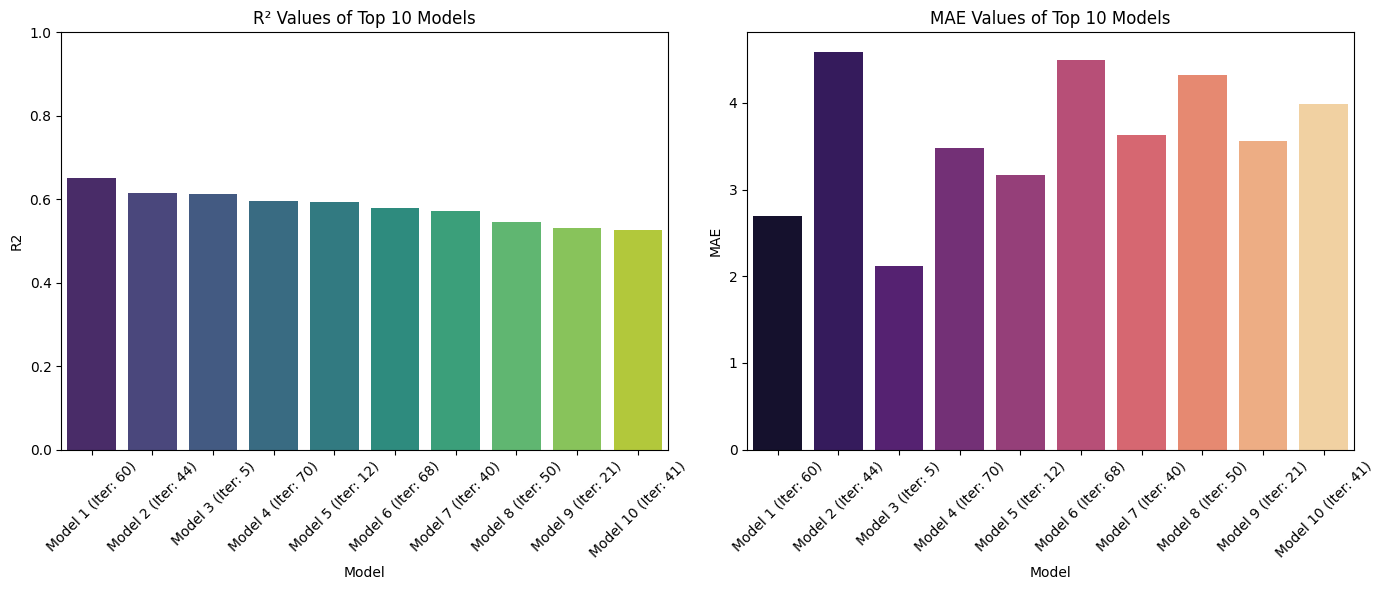

In [27]:
# Set the figure size
plt.figure(figsize=(14, 6))

# Create a bar plot for R2
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='R2', data=results_df, palette='viridis')
plt.title('R² Values of Top 10 Models')
plt.xticks(rotation=45)
plt.ylim(0, 1)  # R² ranges from 0 to 1

# Create a bar plot for MAE
plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='MAE', data=results_df, palette='magma')
plt.title('MAE Values of Top 10 Models')
plt.xticks(rotation=45)

# Show the plots
plt.tight_layout()
plt.show()